## (KOR ver.)How Autoencoders work - Understanding the math and implementation

### Contents 

<ul>
<li>1. Introduction</li>
<ul>
    <li>1.1 What are Autoencoders ? </li>
    <li>1.2 How Autoencoders Work ? </li>
</ul>
<li>2. Implementation and UseCases</li>
<ul>
    <li>2.1 UseCase 1: Image Reconstruction </li>
    <li>2.2 UseCase 2: Noise Removal </li>
    <li>2.3 UseCase 3: Sequence to Sequence Prediction </li>
</ul>
</ul>

<br>

## 1. Introduction
## 1.1 What are Autoencoders 

Autoencoders는 output이 input과 동일한 특수한 유형의 neural network architectures입니다. Autoencoders는 input data의 low level의 representations을 학습하기 위해 un-supervised 방식으로 훈련됩니다. 그런 다음 이러한 low level features는 실제 데이터를 투영하기 위해 다시 변형됩니다. Autoencoders는 네트워크가 입력을 예측하도록 요청하는 regression task입니다 (즉, identity unction 모델링). 이러한 네트워크는 중간에 몇 개의 뉴런의 병목 현상(bottleneck)이 심하기 때문에 입력을 디코더가 원래 입력을 재현하는 데 사용할 수 있는 low-dimensional 코드로 압축하는 효과적인 표현을 생성해야합니다.

전형적인 autoencoder 구조는 3개의 주요 요소로 구성:

- **Encoding Architecture :** Encoding 구조는 노드(node) 수가 감소하는 일련의 계층(layers)으로 구성되며 궁극적으로 latent view representation으로 축소됩니다.
- **Latent View Repersentation :** Latent view는 입력이 감소하고 정보가 보존되는 가장 낮은 수준의 공간을 나타냅니다.
- **Decoding Architecture :** Decoding 구조는 인코딩 구조와 거울에 반사된 듯한 모습을 띄지만 모든 레이어의 노드 수가 증가하여 궁극적으로 유사한 (거의) 입력을 출력합니다.  

![](https://i.imgur.com/Rrmaise.png)

고도로 fine tunning 된 autoencoder 모델은 첫 번째 계층(layer)에서 전달 된 동일한 입력을 재구성 할 수 있어야합니다. 이 kernel에서는 autoencoder의 작동과 그 구현에 대해 설명하겠습니다. Autoencoder는 이미지 데이터와 함께 광범위하게 사용되며 일부 사용 사례는 다음과 같습니다.

- Dimentionality Reduction(차원 축소)
- Image Compression(이미지 압축)   
- Image Denoising(이미지 노이즈 제거)   
- Image Generation(이미지 생성)
- Feature Extraction(feature 추출)  

## 1.2 How Autoencoders work 

먼저 usecase를 설명하기에 앞서 autoencoder에 사용되는 수학을 이해 해야 합니다. Autoencoder의 기본 아이디어는 높은 수준의 차원 데이터에 대한 낮은 수준의 재현(representation)을 학습하는 것입니다. 예를 들어, encoding 절차를 이해해봅시다. Data representation space(데이터 표시 공간)(데이터를 표시하는 데 사용되는 N 차원 공간)을 고려하고 x1과 x2의 두 변수에 의해 표시되는 데이터 포인트를 생각해봅시다. Data manifold는 실제 데이터가 존재하는 data representation spce 내부의 공간입니다.

In [1]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import numpy as np
init_notebook_mode(connected=True)

## generate random data
N = 50
random_x = np.linspace(2, 10, N)
random_y1 = np.linspace(2, 10, N)
random_y2 = np.linspace(2, 10, N)

trace1 = go.Scatter(x = random_x, y = random_y1, mode="markers", name="Actual Data")
trace2 = go.Scatter(x = random_x, y = random_y2, mode="lines", name="Model")
layout = go.Layout(title="2D Data Repersentation Space", xaxis=dict(title="x2", range=(0,12)), 
                   yaxis=dict(title="x1", range=(0,12)), height=400, 
                   annotations=[dict(x=5, y=5, xref='x', yref='y', text='This 1D line is the Data Manifold (where data resides)',
                   showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='#636363',
                   ax=-120, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='orange', opacity=0.8)])
figure = go.Figure(data = [trace1], layout = layout)
iplot(figure)

이 데이터를 표시하기 위해 현재 X와 Y의 2 차원을 사용하고 있습니다. 그러나 이 공간의 차원을 더 낮은 차원(즉, 1D)으로 줄일 수 있습니다.

다음과 같이 정의할 수 있습니다:

- Line 상의 기준점: A  
- 수평축으로 부터 각도: L


그렇다면 line A 위의 다른 지점(예: B)은 A로부터 거리 "d" 및 각도 L의 관점으로 표현할 수 있습니다.

In [2]:
random_y3 = [2 for i in range(100)]
random_y4 = random_y2 + 1
trace4 = go.Scatter(x = random_x[4:24], y = random_y4[4:300], mode="lines")
trace3 = go.Scatter(x = random_x, y = random_y3, mode="lines")
trace1 = go.Scatter(x = random_x, y = random_y1, mode="markers")
trace2 = go.Scatter(x = random_x, y = random_y2, mode="lines")
layout = go.Layout(xaxis=dict(title="x1", range=(0,12)), yaxis=dict(title="x2", range=(0,12)), height=400,
                   annotations=[dict(x=2, y=2, xref='x', yref='y', text='A', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, 
                                     arrowcolor='#636363', ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='orange', opacity=0.8), 
                                dict(x=6, y=6, xref='x', yref='y', text='B', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='#636363',
                                     ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='yellow', opacity=0.8), dict(
                                     x=4, y=5, xref='x', yref='y',text='d', ay=-40), 
                                dict(x=2, y=2, xref='x', yref='y', text='angle L', ax=80, ay=-10)], title="2D Data Repersentation Space", showlegend=False)
data = [trace1, trace2, trace3, trace4]
figure = go.Figure(data = data, layout = layout)
iplot(figure)



#################

random_y3 = [2 for i in range(100)]
random_y4 = random_y2 + 1
trace4 = go.Scatter(x = random_x[4:24], y = random_y4[4:300], mode="lines")
trace3 = go.Scatter(x = random_x, y = random_y3, mode="lines")
trace1 = go.Scatter(x = random_x, y = random_y1, mode="markers")
trace2 = go.Scatter(x = random_x, y = random_y2, mode="lines")
layout = go.Layout(xaxis=dict(title="u1", range=(1.5,12)), yaxis=dict(title="u2", range=(1.5,12)), height=400,
                   annotations=[dict(x=2, y=2, xref='x', yref='y', text='A', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, 
                                     arrowcolor='#636363', ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='orange', opacity=0.8), 
                                dict(x=6, y=6, xref='x', yref='y', text='B', showarrow=True, align='center', arrowhead=2, arrowsize=1, arrowwidth=2, arrowcolor='#636363',
                                     ax=20, ay=-30, bordercolor='#c7c7c7', borderwidth=2, borderpad=4, bgcolor='yellow', opacity=0.8), dict(
                                     x=4, y=5, xref='x', yref='y',text='d', ay=-40), 
                                dict(x=2, y=2, xref='x', yref='y', text='angle L', ax=80, ay=-10)], title="Latent Distance View Space", showlegend=False)
data = [trace1, trace2, trace3, trace4]
figure = go.Figure(data = data, layout = layout)
iplot(figure)

그러나 여기서 핵심적인 질문은 어떤 논리 또는 어떤 규칙으로, 점 B는 A와 각도 L로 표현 될 수 있는지입니다. 또는 다른 용어로 B, A 및 L 사이의 방정식은 어떻게 표현됩니까? 답은 "정해진 방정식은 없지만 비지도 학습과정을 통해 최상의 방정식을 얻을 수 있다." 입니다. 간단히 말해서 학습 과정은 B를 A와 L의 형태로 변환하는 규칙/방정식으로 정의 할 수 있습니다. Autoencoder 관점에서 이 과정을 이해합시다.

숨겨진 레이어(hidden layer)가 없는 autoencoder를 고려하면 입력 x1 및 x2는 더 낮은 repersentation d로 인코딩 된 다음 x1 및 x2에 추가로 투영됩니다.

![](https://i.imgur.com/lfq4eEy.png)

<br>
**Step1 : Repersent the points in Latent View Space**   

데이터 표현 공간에서 점 A와 B의 좌표가 다음과 같은 경우:

- Point A : (x1A, x2A)  
- Point B : (x1B, x2B)   

잠재 뷰 공간에서의 좌표는 다음과 같습니다.

(x1A, x2A) ---> (0, 0)  
(x1B, x2B) ---> (u1B, u2B)  

- Point A : (0, 0)  
- Point B : (u1B, u2B)   

여기서 u1B와 u2B는 점과 기준점 사이의 거리 형태로 표현 될 수 있습니다.

u1B = x1B - x1A  
u2B = x2B - x2A

**Step2 : Represent the points with distance d and angle L **    

이제 u1B와 u2B는 거리 d와 각도 L의 조합으로 표현할 수 있습니다. 그리고 이것을 각도 L만큼, 수평축 쪽으로 회전하면 L은 0이됩니다. 즉, 

**=> (d, L)**     
**=> (d, 0)**   (after rotation)   

이것은 인코딩 프로세스의 출력이며 데이터를 낮은 차원으로 표시합니다. 모든 계층의 가중치와 편향을 갖는 신경망의 기본 방정식을 상기하면,

**=> (d, 0) = W. (u1B, u2B)**    
==> (encoding)    

여기서 W는 은닉층의 가중치 행렬입니다. 따라서 디코딩 프로세스는 인코딩 프로세스의 미러 이미지라는 것을 알고 있습니다.

**=> (u1B, u2B) = Inverse (W) . (d, 0)**    
==> (decoding)  

축소 된 형태의 데이터 (x1, x2)는 인코딩 아키텍처에서 얻은 잠재 뷰 공간에서 (d, 0)입니다. 마찬가지로 디코딩 구조는 이 표현을 원래 형식 (u1B, u2B)으로 다시 변환 한 다음 (x1, x2)로 변환합니다. 중요한 점은 데이터 유형에 따라 규칙/학습 기능/인코딩 디코딩 방정식이 다를 수 있다는 것입니다. 예를 들어 2 차원 공간에서 다음 데이터를 고려해보십쇼.


## Different Rules for Different data

모든 유형의 데이터에 동일한 규칙을 적용 할 수는 없습니다. 예를 들어, 이전 예에서 선형 데이터 매니 폴드를 한 차원으로 투영하고 각도 L을 제거했습니다. 그러나 데이터 매니 폴드를 제대로 투영 할 수 없는 경우에는 어떻게 해야합니까? 예를 들어, 다음 데이터 매니 폴드보기를 고려하십시오.

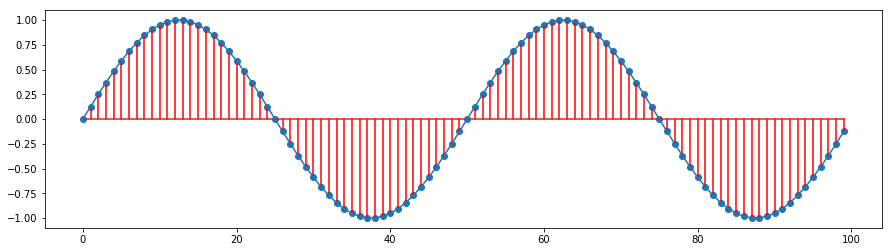

In [3]:
import matplotlib.pyplot as plt 
import numpy as np
fs = 100 # sample rate 
f = 2 # the frequency of the signal
x = np.arange(fs) # the points on the x axis for plotting
y = [ np.sin(2*np.pi*f * (i/fs)) for i in x]

% matplotlib inline
plt.figure(figsize=(15,4))
plt.stem(x,y, 'r', );
plt.plot(x,y);

이러한 유형의 데이터에서 핵심 문제는 정보 손실없이 단일 차원의 데이터 프로젝션을 얻는 것입니다. 이러한 유형의 데이터를 latent space에 projection하면 많은 정보가 손실되고 이를 변형하여 원래 모양으로 투사하는 것이 거의 불가능합니다. 아무리 많은 평행이동(shift)와 회전(rotation)이 적용되어도 원본 데이터는 복구 할 수 없습니다.

그렇다면 신경망은 이 문제를 어떻게 해결해야 할까요? 직관적으로 생각해보면, 매니 폴드 공간(manifold space)에서 심층 신경망은 선형 데이터 폴드 뷰(fold view)를 얻기 위해 공간(space)을 구부(bend)리는 속성을 가지고 있습니다. Autoencoder 구조는 숨겨진 레이어에 이 속성을 적용하여 잠재 뷰 공간(latent view space)에서 낮은 수준의 표현을 학습 할 수 있습니다.

다음 이미지는 이 속성을 설명합니다.

![](https://i.imgur.com/gKCOdiL.png)

먼저 이미지에서 특징을 학습 한 다음 출력과 동일한 이미지를 투사하는 Keras를 사용하여 autoencoder를 구현해 보겠습니다.

## 2. Implementation

## 2.1 UseCase 1 : Image Reconstruction

1. 필요한 library들을 불러옵니다.


In [4]:
## load the libraries 
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np

Using TensorFlow backend.


### 2. Dataset Prepration 

데이터 세트를 불러오고, 예측 변수와 대상을 분리하고, 입력을 정규화합니다.

In [5]:
### read dataset 
train = pd.read_csv("../input/fashion-mnist_train.csv")
train_x = train[list(train.columns)[1:]].values
train_y = train['label'].values

## normalize and reshape the predictors  
train_x = train_x / 255

## create train and validation datasets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

## reshape the inputs
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

### 3. Create Autoencoder architecture

이 섹션에서는 autoencoder 구조를 작성해보겠습니다. 인코딩 부분은 2000, 1200 및 500 노드가 있는 3개의 레이어로 구성됩니다. 인코딩 아키텍처는 10개의 노드로 구성된 latent view space에 연결되고 500, 1200 및 2000 노드가 있는 디코딩 아키텍처에 연결됩니다. 최종 계층은 입력 계층과 같은 수의 노드로 구성됩니다.

In [6]:
## input layer
input_layer = Input(shape=(784,))

## encoding architecture
encode_layer1 = Dense(1500, activation='relu')(input_layer)
encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
latent_view   = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(500, activation='relu')(latent_view)
decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
output_layer  = Dense(784)(decode_layer3)

model = Model(input_layer, output_layer)

다음은 autoencoder 구조에 대한 요약입니다.

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              1177500   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_3 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               5500      
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              501000    
__________

다음으로 조기 중지 콜백(early stop callback)으로 모델을 학습합니다.

In [8]:
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(train_x, train_x, epochs=20, batch_size=2048, validation_data=(val_x, val_x), callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 30s 615us/step - loss: 0.0968 - val_loss: 0.0682
Epoch 2/20
48000/48000 [==============================] - 21s 428us/step - loss: 0.0634 - val_loss: 0.0563
Epoch 3/20
48000/48000 [==============================] - 20s 423us/step - loss: 0.0496 - val_loss: 0.0460
Epoch 4/20
48000/48000 [==============================] - 21s 432us/step - loss: 0.0410 - val_loss: 0.0388
Epoch 5/20
48000/48000 [==============================] - 20s 426us/step - loss: 0.0372 - val_loss: 0.0362
Epoch 6/20
48000/48000 [==============================] - 21s 431us/step - loss: 0.0343 - val_loss: 0.0328
Epoch 7/20
48000/48000 [==============================] - 21s 429us/step - loss: 0.0306 - val_loss: 0.0285
Epoch 8/20
48000/48000 [==============================] - 21s 430us/step - loss: 0.0273 - val_loss: 0.0264
Epoch 9/20
48000/48000 [==============================] - 21s 434us/step - loss: 0.0255 - val_

검증 데이터에 대한 예측을 생성합니다.

In [9]:
preds = model.predict(val_x)

원본 이미지와 예측 이미지를 시각화 해봅시다.

**Inputs: Actual Images**

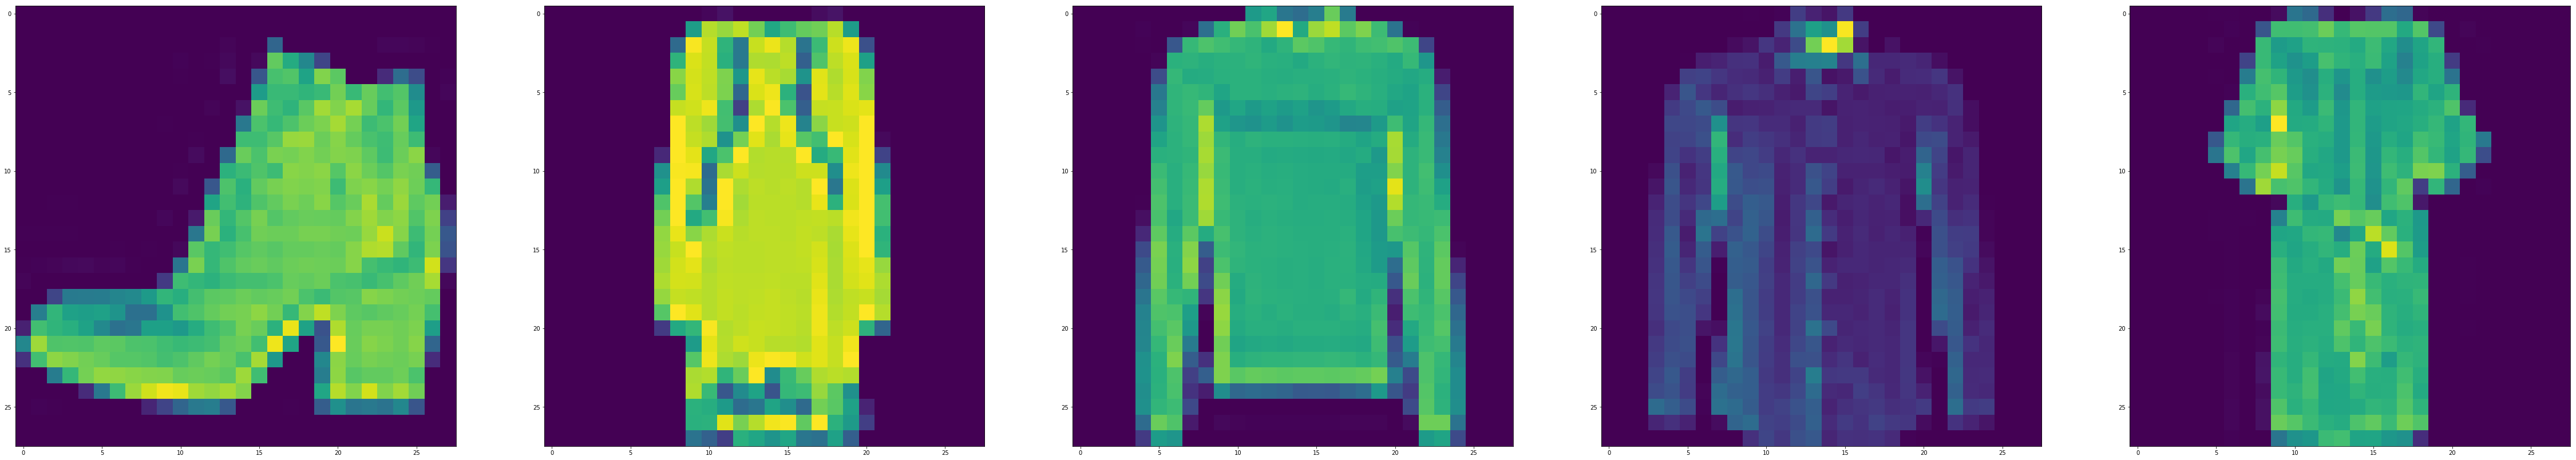

In [10]:
from PIL import Image 
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(val_x[i].reshape(28, 28))
plt.show()

**Predicted : Autoencoder Output**

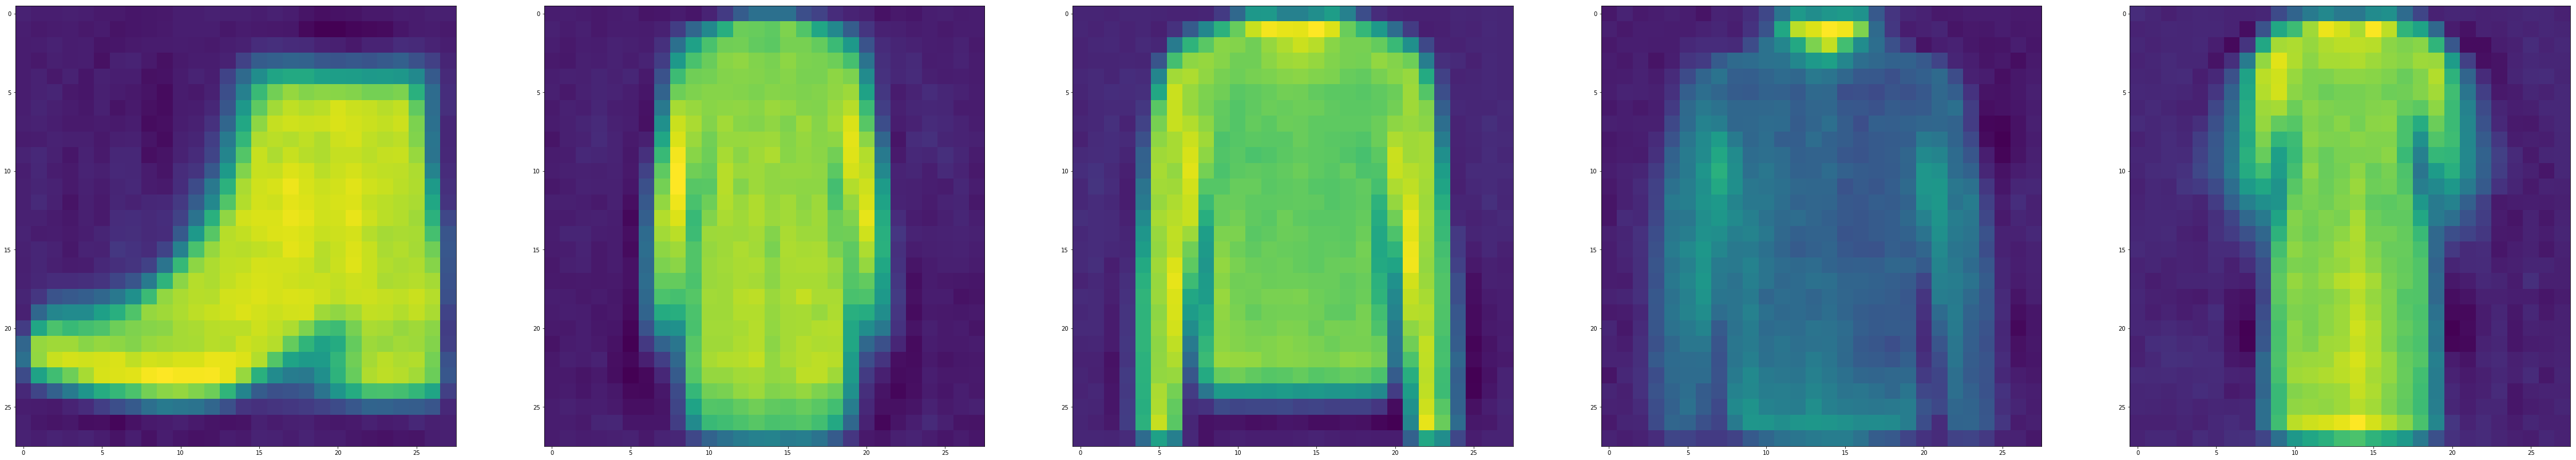

In [11]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(preds[i].reshape(28, 28))
plt.show()

따라서 20개의 epoch로 훈련 된 autoencoder가 입력 이미지를 매우 잘 재구성 할 수 있음을 확인할 수 있습니다. autoencoder의 다른 사용 사례를 살펴 보겠습니다. Image denoising 또는 removal of noise from the image라 불리는 이미지 노이즈제거.

## 2.2 UseCase 2 - Image Denoising

Autoencoder는 매우 유용합니다. Autoencoder의 또 다른 애플리케이션인 이미지 노이즈 제거에 대해 살펴 보겠습니다. 입력 이미지에는 데이터에 노이즈가 포함되어 있는 경우가 많으며 autoencoder를 사용하여 해당 이미지의noise를 제거 할 수 있습니다. 실제로 구현해봅시다. 먼저 이미지 픽셀을 구성하는 train_x 및 val_x 데이터를 준비합니다.

![](https://www.learnopencv.com/wp-content/uploads/2017/11/denoising-autoencoder-600x299.jpg)

In [12]:
## recreate the train_x array and val_x array
train_x = train[list(train.columns)[1:]].values
train_x, val_x = train_test_split(train_x, test_size=0.2)

## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

이 autoencoder 네트워크에서는 convolution 네트워크가 이미지 입력과 잘 작동하기 때문에 convolutional layer를 추가 할 것입니다. 이미지 데이터에 convolution을 적용하기 위해 28 * 28 행렬의 형태로 입력을 재구성합니다. CNN에 대한 자세한 내용은 저자의 이전 [kernel](https://www.kaggle.com/shivamb/a-very-comprehensive-tutorial-nn-cnn)을 참고하세요.  

In [13]:
train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

### Noisy Images 

이미지에 의도적으로 노이즈를 도입 할 수 있습니다. 다양한 변형으로 이미지를 보강(augmentation)하는 데 사용할 수있는 imaug 패키지를 사용하고 있습니다. 이러한 변형 중 하나는 노이즈 추가입니다. 이미지에 다양한 유형의 노이즈를 추가 할 수 있습니다. 예를 들면,

- Salt and Pepper Noise  
- Gaussian Noise  
- Periodic Noise  
- Speckle Noise  

Impulse 노이즈라고도 하는 salt and pepper 노이즈를 이미지에 적용해보겠습니다. 이 노이즈는 이미지 신호에 날카롭고 갑작스러운 장애를 유발합니다. 드물게 흰색 및 검정색 픽셀로 이미지에 표현되기도 합니다.

In [14]:
# Lets add sample noise - Salt and Pepper
noise = augmenters.SaltAndPepper(0.1)
seq_object = augmenters.Sequential([noise])

train_x_n = seq_object.augment_images(train_x * 255) / 255
val_x_n = seq_object.augment_images(val_x * 255) / 255

noise 추가하기 전,

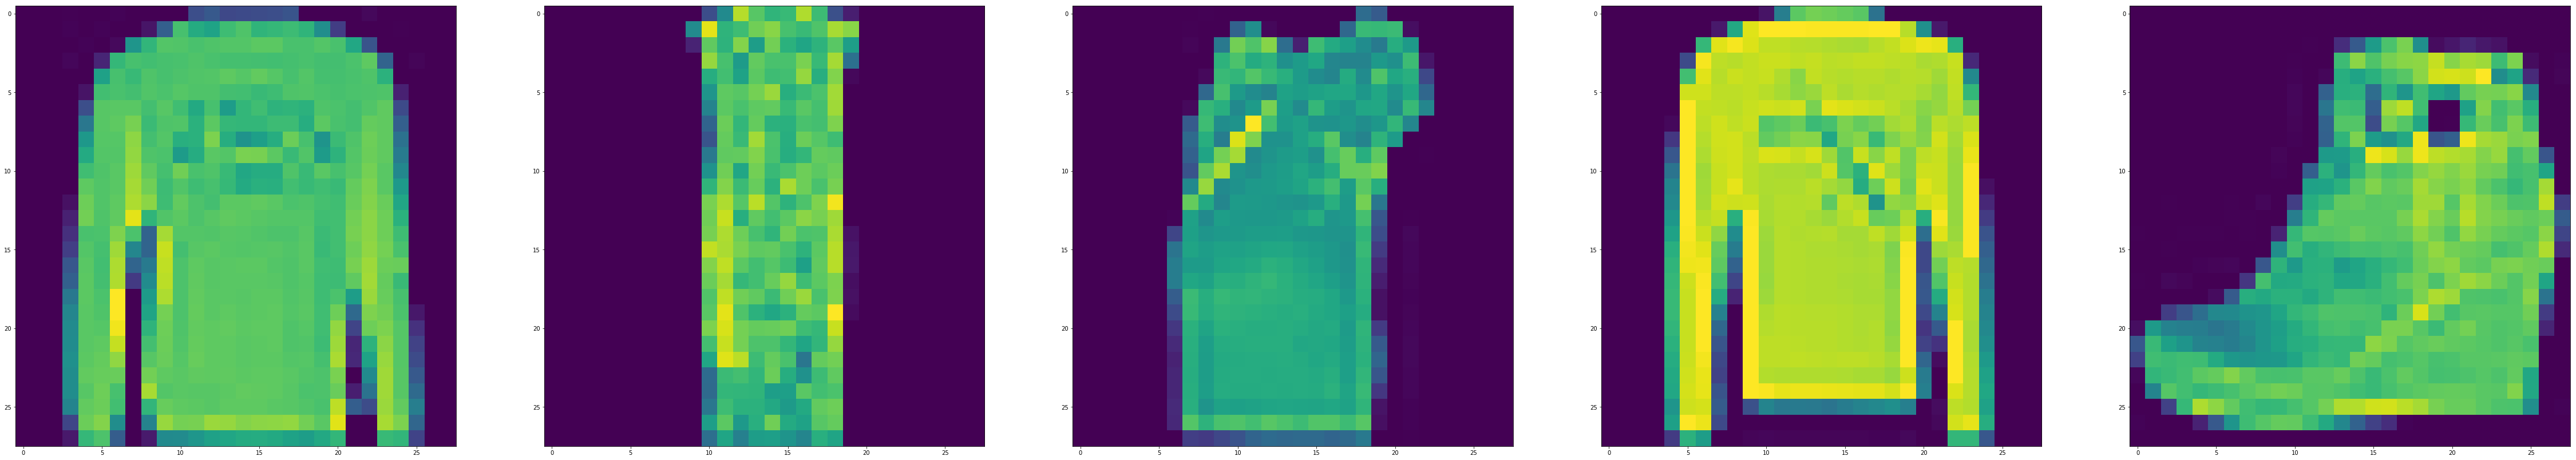

In [15]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x[i].reshape(28, 28))
plt.show()

noise를 추가하면,

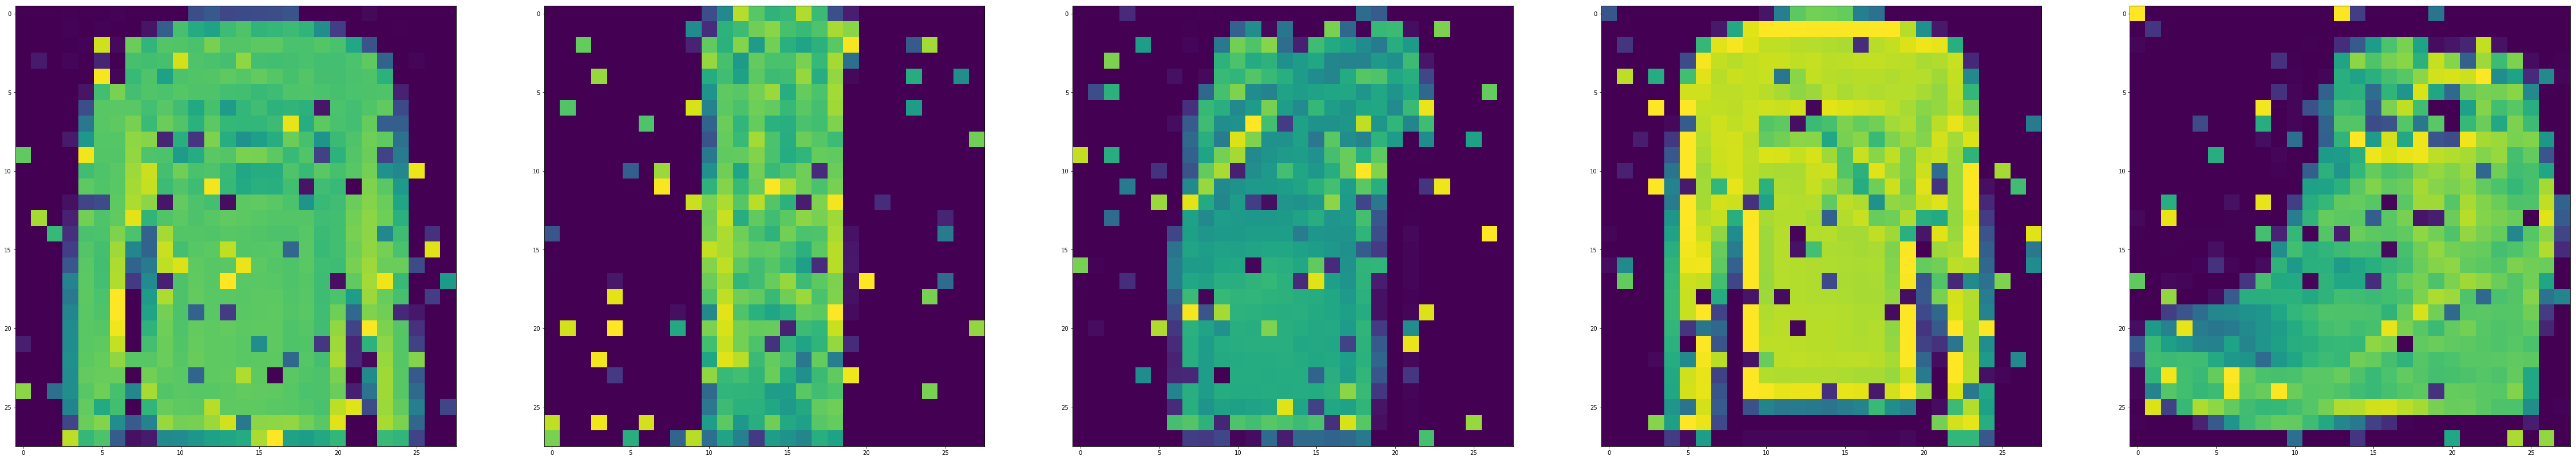

In [16]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_x_n[i].reshape(28, 28))
plt.show()

이제 autoencoder를 위한 모델 구조를 생성하겠습니다. 이 문제에 대해 어떤 유형의 네트워크를 만들어야하는지 이해해봅시다.

**Encoding Architecture:**   

인코딩 구조는 3 개의 Convolutional Layers와 3 개의 Max Pooling Layers로 구성되어 있습니다. Relu는 Convolutional Layers에서 활성화 함수로 사용되며 패딩은 "same"으로 설정합니다. Max Pooling Layers의 역할은 이미지 차원을 다운 샘플링(down sampling)하는 것입니다. 이 layer는 초기 표현의 겹치지 않는 하위 영역에 최대 필터(max filter)를 적용합니다.

**Decoding Architecture:**   

디코딩 아키텍처에서도 유사하게, Convolutional Layers는 인코딩 구조와 동일한 차원(역방향 방식)을 갖습니다. 그러나 3 개의 Max Pooling Layers 대신 3 개의 업 샘플링(up-sampling) 레이어를 추가합니다. 활성화 함수는 동일하며(relu) Convolutional Layers의 패딩도 동일합니다. 업 샘플링 레이어의 역할은 입력 벡터의 차원을 더 높은 해상도/차원으로 업 샘플링하는 것입니다. Max Pooling 작업은 비가역적이지만 각 pooling 영역 내에서 최대 값의 위치를 ​​기록하여 대략적인 역(inverse)을 얻을 수 있습니다. Up-sampling layer는 이 속성을 사용하여 낮은 차원의 특징 공간에서 재구성을 투영(project)합니다.  



In [17]:
# input layer
input_layer = Input(shape=(28, 28, 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)

# compile the model
model_2 = Model(input_layer, output_layer)
model_2.compile(optimizer='adam', loss='mse')

만든 model의 요약입니다.

In [18]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
__________

조기 중지 콜백(callback)으로 모델을 훈련시킵니다. 더 나은 결과를 얻고 싶으면 적힌 epoch보다 더 큰 수로 학습시키세요.

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = model_2.fit(train_x_n, train_x, epochs=10, batch_size=2048, validation_data=(val_x_n, val_x), callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 226s 5ms/step - loss: 0.0879 - val_loss: 0.0534
Epoch 2/10
48000/48000 [==============================] - 214s 4ms/step - loss: 0.0451 - val_loss: 0.0393
Epoch 3/10
48000/48000 [==============================] - 214s 4ms/step - loss: 0.0360 - val_loss: 0.0332
Epoch 4/10
48000/48000 [==============================] - 235s 5ms/step - loss: 0.0310 - val_loss: 0.0291
Epoch 5/10
48000/48000 [==============================] - 218s 5ms/step - loss: 0.0277 - val_loss: 0.0266
Epoch 6/10
48000/48000 [==============================] - 215s 4ms/step - loss: 0.0258 - val_loss: 0.0253
Epoch 7/10
48000/48000 [==============================] - 232s 5ms/step - loss: 0.0242 - val_loss: 0.0235
Epoch 8/10
48000/48000 [==============================] - 216s 4ms/step - loss: 0.0231 - val_loss: 0.0226
Epoch 9/10
48000/48000 [==============================] - 216s 4ms/step - loss: 0.0220 - val_loss: 0.0

모델을 사용하여 예측을 얻을 수 있습니다.

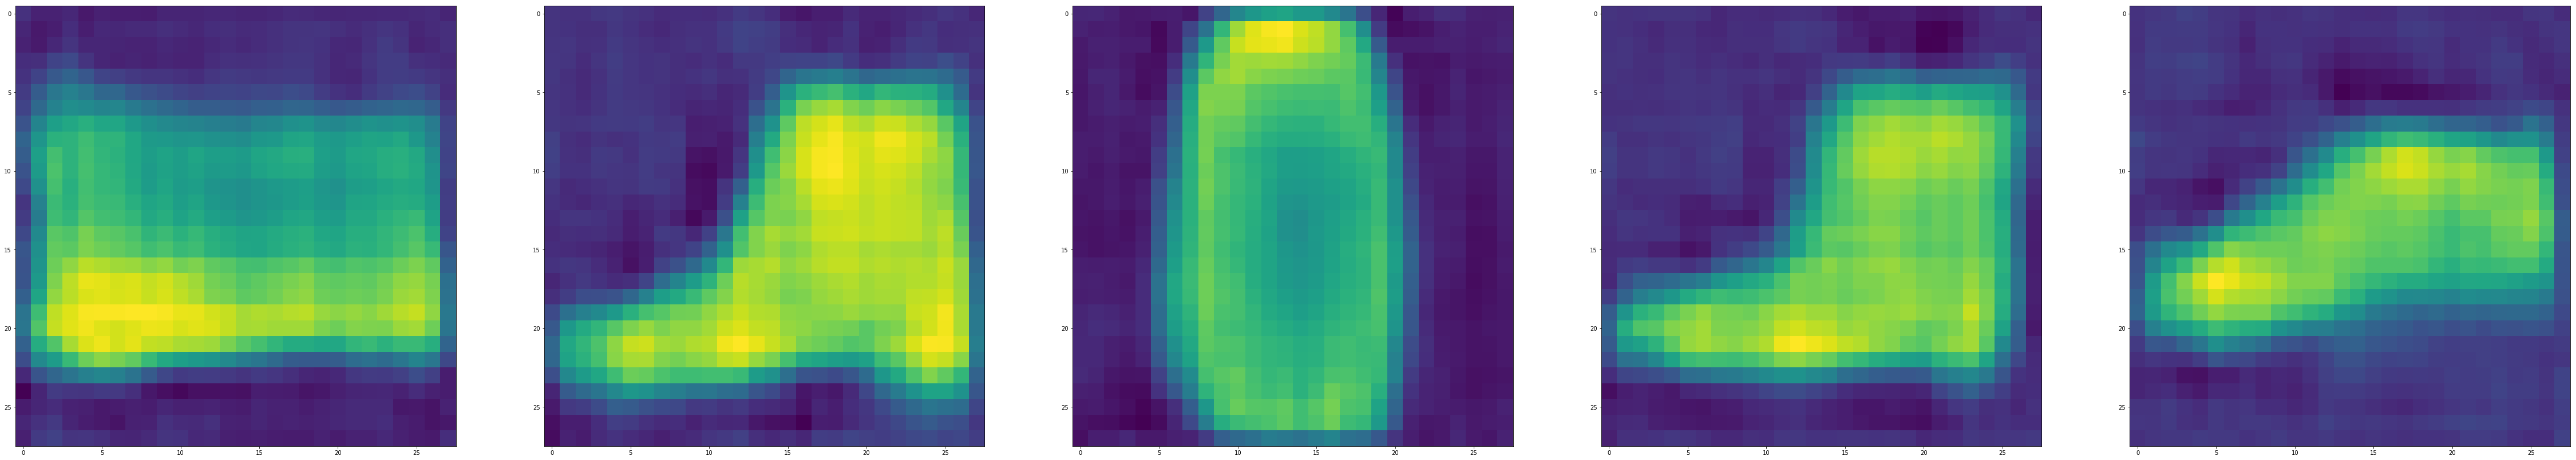

In [20]:
preds = model_2.predict(val_x_n[:10])
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(preds[i].reshape(28, 28))
plt.show()

이 구현에서는 10 epoch 만 학습을 시켰지만, 더 많은 epoch에 대해 이 네트워크를 학습한다면 더 나은 예측 결과를 확인할 수 있습니다. (e.g. 500 ~ 1000 epochs)


## 2.3 UseCase 3: Sequence to Sequence Prediction using AutoEncoders


다음 usecase는 sequence 대 sequence 예측입니다. 이전 예제에서는 기본적으로 2 차원 데이터인 이미지를 입력으로 사용했습니다. 이번 예제에서는 1 차원인 sequence 데이터를 입력으로 사용합니다. Sequence 데이터의 예로는 시계열 데이터와 텍스트 데이터가 있습니다. 이 usecase는 기계 번역(Machine translation)에 적용될 수 있습니다. 이미지 예제의 CNN과 달리 이 uscase에서는 LSTM을 사용합니다.


이 섹션의 코드 대부분은 Jason Brownie가 운영하는 블로그 게시물을 참조하였습니다.

- Reference : https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/

#### Autoencoder Architecture  

이 usecase의 구조는 소스(source) sequence를 인코딩하는 인코더와 인코딩 된 소스 sequence를 디코딩하는 디코더로 구성됩니다. 먼저 이 구조에서 사용될 LSTM의 내부 precess를 이해해보도록 하겠습니다.

- Long Short-Term Memory, or LSTM, 은 내부 게이트(gate)로 구성된 순환 신경망입니다. 
- 다른 순환 신경망과 달리 네트워크의 내부 게이트를 사용하면 시간에 따른 역전파 또는 BPTT를 사용하여 모델을 성공적으로 학습시키고 기울기 소실 문제(vanishing gradients problem)를 방지 할 수 있습니다.
- LSTM 계층에서 LSTM 메모리 단위의 수를 정의 할 수 있습니다. 계층 내의 각 단위 또는 셀은 내부 메모리/셀 상태(c)를 가지며 종종 h라는 표현을 사용하는 숨겨진 상태를 출력합니다.
- Keras를 사용하면 LSTM 계층의 출력 상태와 LSTM 계층의 현재 상태에 모두 액세스 할 수 있습니다.

이제 LSTM 레이어로 구성된 sequence를 학습하고 생성하기 위한 autoencoder 구조를 생성하겠습니다. 두 가지 구성 요소가 존재합니다. 

- Sequence를 입력으로 사용하고 LSTM의 현재 상태를 출력으로 반환하는 인코더 구조  
- Sequence 및 인코더 LSTM 상태를 입력으로 사용하고 디코딩 된 출력 sequence를 반환하는 디코더 구조
- 보이지 않는 데이터에 대한 예측을 생성하는 동안 사용할 수 있도록 LSTM의 숨김 및 메모리 상태를 저장하고 액세스합니다. 

먼저 고정 길이의 무작위 sequence를 포함하는 sequence 데이터 세트를 생성하겠습니다. 무작위 sequence를 생성하는 함수를 정의할 것입니다.

- X1은 난수를 포함하는 입력 sequence를 표시합니다.
- X2는 sequence의 다른 요소를 재현하기 위해 시드(seed)로 사용되는 패딩(padding) 된 sequence를 나타냅니다.
- y는 타겟 sequence 또는 실제 sequence를 나타냅니다. 


In [21]:
def dataset_preparation(n_in, n_out, n_unique, n_samples):
    X1, X2, y = [], [], []
    for _ in range(n_samples):
        ## create random numbers sequence - input 
        inp_seq = [randint(1, n_unique-1) for _ in range(n_in)]
        
        ## create target sequence
        target = inp_seq[:n_out]
    
        ## create padded sequence / seed sequence 
        target_seq = list(reversed(target))
        seed_seq = [0] + target_seq[:-1]  
        
        # convert the elements to categorical using keras api
        X1.append(to_categorical([inp_seq], num_classes=n_unique))
        X2.append(to_categorical([seed_seq], num_classes=n_unique))
        y.append(to_categorical([target_seq], num_classes=n_unique))
    
    # remove unnecessary dimention
    X1 = np.squeeze(np.array(X1), axis=1) 
    X2 = np.squeeze(np.array(X2), axis=1) 
    y  = np.squeeze(np.array(y), axis=1) 
    return X1, X2, y

samples = 100000
features = 51
inp_size = 6
out_size = 3

inputs, seeds, outputs = dataset_preparation(inp_size, out_size, features, samples)
print("Shapes: ", inputs.shape, seeds.shape, outputs.shape)
print ("Here is first categorically encoded input sequence looks like: ", )
inputs[0][0]

Shapes:  (100000, 6, 51) (100000, 3, 51) (100000, 3, 51)
Here is first categorically encoded input sequence looks like: 


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

다음으로 Keras에서 모델의 구조를 생성해 보겠습니다.

In [22]:
def define_models(n_input, n_output):
    ## define the encoder architecture 
    ## input : sequence 
    ## output : encoder states 
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(128, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]

    ## define the encoder-decoder architecture 
    ## input : a seed sequence 
    ## output : decoder states, decoded output 
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    ## define the decoder model
    ## input : current states + encoded sequence
    ## output : decoded sequence
    encoder_model = Model(encoder_inputs, encoder_states)
    decoder_state_input_h = Input(shape=(128,))
    decoder_state_input_c = Input(shape=(128,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

    return model, encoder_model, decoder_model

autoencoder, encoder_model, decoder_model = define_models(features, features)

### Model 구조를 살펴보자

Encoder 구조 요약

In [23]:
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, 51)          0         
_________________________________________________________________
lstm_1 (LSTM)                [(None, 128), (None, 128) 92160     
Total params: 92,160
Trainable params: 92,160
Non-trainable params: 0
_________________________________________________________________


Decoder 구조 요약

In [24]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, 51)     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  92160       input_4[0][0]                    
                                                                 input_5[0][0]                    
          

Autoencoder 구조 요약

In [25]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 51)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None, 51)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 128), (None, 92160       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  92160       input_4[0][0]                    
                                                                 lstm_1[0][1]                     
          

이제 Adam Optimizer 및 Categorical Cross Entropy loss 함수를 사용하여 autoencoder 모델을 학습 해 보겠습니다.

In [26]:
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
autoencoder.fit([inputs, seeds], outputs, epochs=1)

Epoch 1/1
100000/100000 [==============================] - 49s 490us/step - loss: 0.6490 - acc: 0.7933


Input sequence 기반으로 sequence를 예측하는 함수를 작성해보자.

In [27]:
def reverse_onehot(encoded_seq):
    return [argmax(vector) for vector in encoded_seq]

def predict_sequence(encoder, decoder, sequence):
    output = []
    target_seq = np.array([0.0 for _ in range(features)])
    target_seq = target_seq.reshape(1, 1, features)

    current_state = encoder.predict(sequence)
    for t in range(out_size):
        pred, h, c = decoder.predict([target_seq] + current_state)
        output.append(pred[0, 0, :])
        current_state = [h, c]
        target_seq = pred
    return np.array(output)

### Generate some predictions

In [28]:
for k in range(5):
    X1, X2, y = dataset_preparation(inp_size, out_size, features, 1)
    target = predict_sequence(encoder_model, decoder_model, X1)
    print('\nInput Sequence=%s SeedSequence=%s, PredictedSequence=%s' 
          % (reverse_onehot(X1[0]), reverse_onehot(y[0]), reverse_onehot(target)))


Input Sequence=[26, 49, 45, 45, 40, 28] SeedSequence=[45, 49, 26], PredictedSequence=[45, 49, 26]

Input Sequence=[9, 22, 11, 10, 33, 25] SeedSequence=[11, 22, 9], PredictedSequence=[11, 22, 9]

Input Sequence=[10, 20, 37, 24, 7, 28] SeedSequence=[37, 20, 10], PredictedSequence=[37, 20, 10]

Input Sequence=[12, 9, 41, 49, 44, 15] SeedSequence=[41, 9, 12], PredictedSequence=[41, 9, 12]

Input Sequence=[18, 17, 27, 8, 29, 28] SeedSequence=[27, 17, 18], PredictedSequence=[27, 17, 18]



### Excellent References

1. https://www.analyticsvidhya.com/blog/2018/06/unsupervised-deep-learning-computer-vision/
2. https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798
3. https://blog.keras.io/building-autoencoders-in-keras.html
4. https://cs.stanford.edu/people/karpathy/convnetjs/demo/autoencoder.html  
5. https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/


Thanks for viewing the kernel, **please upvote** if you liked it. 